# Model 3 - CNN+RNN using both geo-spatial and kinematic features

In [1]:
!pip install datashader
!apt-get install libgeos++ libproj-dev
!pip install geoviews

     |████████████████████████████████| 15.5MB 202kB/s 
     |████████████████████████████████| 1.6MB 54.3MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
     |████████████████████████████████| 102kB 16.1MB/s 
     |████████████████████████████████| 675kB 59.4MB/s 
     |████████████████████████████████| 102kB 15.8MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp36-none-any.whl size=59430 sha256=7394c6c463566df180cf378d9b4678f04f3fa01ed915161a884ec625b640d772
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=9057c42fceaefcad58bf0f7f243af8db5f877bf23e00e4642fc45d2cccf03699
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4042 sha256=72438ba53dadde5dcf78ce50a639c675906d75235cd9484ed12

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import math
from google.colab import drive
drive.mount("/content/drive")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Mounted at /content/drive


In [4]:
userID = 'Klara' #@param ["Jonas", "Klara", "Sara"]

if 'j' in userID[0].lower():
  working_path = "/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch-master/deep_project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d '/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch-master/deep_project/DataLoaderForStudents'
    os.chdir(working_path) #Jonas connection
elif 's' in userID[0].lower():
  working_path = "/content/drive/My Drive/Deep Learning/project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d "/content/drive/My Drive/Deep Learning/project/DataLoaderForStudents"
    os.chdir(working_path) #Sara connection
else:
  working_path = "/content/drive/My Drive/project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d "/content/drive/My Drive/project/DataLoaderForStudents"
    os.chdir(working_path) #Klara connection

In [5]:
sys.path.append(f'{working_path}/MMM_DataLoaderForStudents/src')
from data_utils_conda import *
clear_output(wait=False)

In [6]:
from modelClassC import *

### Load train, validation and test data

In [7]:
random.seed(123)
user_train, user_val, user_test = train, val, test = train_test_data_split(Random = True)
user_train = [user for user in user_train if user!=4]
user_test = [user for user in user_test if user!=9]
print("We train on users {}\n we validate on users {}\n and we test on users {}".format(user_train,user_val,user_test))

We train on users [0, 1, 6, 10, 11, 8, 3]
 we validate on users [2]
 and we test on users [5, 7]


### Set time interval and speed cut off

In [8]:
# get data
dataset = decompress_pickle(f'{working_path}/MMM_DataLoaderForStudents/Pickle/dataSet.pbz2')
dataset.rename(columns = {"label": "label2"})
labelMeaning = pd.read_csv(f'{working_path}/MMM_DataLoaderForStudents/UID-MMM-labels.csv').drop(columns='Unnamed: 0')[['stop','mode','howTravelled','purpose','mainActivity']]
labelMeaning.head()

,stop,mode,howTravelled,purpose,mainActivity
0,1,0,-100,14,Work
1,2,5,Foot,0,-100
2,1,0,-100,0,-100
3,2,5,Foot,0,-100
4,1,0,-100,14,Work


In [9]:
# change index to 0/1
dataset.label2 = dataset.label2-1

In [10]:
# image_ix:             ???
# segment_point_count:  length of minimum seq to infer on
# segment_ix:           step in trip
# segment_id:           where we are on grid ? (each sequence is split by cutoff_speed/time and labelled)
# tod:                  ???

In [11]:
dataset["labelC"] = dataset.labelP.copy()
dataset.loc[dataset.labelC!=0,'labelC'] += len(dataset.labelM.unique())-1
dataset.loc[dataset.labelC==0,'labelC'] = dataset.loc[dataset.labelC==0,'labelM']
dataset.loc[dataset.labelC>17,'labelC'] = dataset.loc[dataset.labelC>17,'labelC'] - 1
#dataset.labelC[dataset.labelC == 0] = dataset.labelP[dataset.labelC == 0]+len(dataset.labelM.unique())
print(len(dataset.labelC.unique()),np.sort(dataset.labelC.unique()))
#for i in range(len(dataset)):
#  if dataset.labelC[i] == 0:
#    dataset.labelC[i] = dataset.labelP[i]+len(dataset.labelM.unique())

23 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [12]:
dataset.head()

,user,ts,image_ix,label2,labelP,labelM,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count,labelC
0,1,2018-06-25 09:57:31+00:00,1,0,3,0,671.0,7.751420,-1.856730,0.011552,1,1,0,1,11
1,1,2018-06-25 09:58:43+00:00,4,1,0,4,72.0,133.415960,-2.005347,1.852999,1,2,0,1,4
2,1,2018-06-25 09:58:44+00:00,5,1,0,4,1.0,57.104376,-1.252389,57.104376,1,3,0,1,4
3,1,2018-06-25 09:58:45+00:00,6,1,0,4,1.0,47.314571,1.864483,47.314571,1,4,0,606,4
4,1,2018-06-25 09:58:46+00:00,7,1,0,4,1.0,7.512082,2.876788,7.512082,1,4,1,606,4


In [13]:
tmphT = list(labelMeaning.howTravelled.unique())
tmpM = list(labelMeaning['mode'].unique())

In [14]:
#labelMeaning.loc[labelMeaning['purpose_mode']!=0,'purpose_mode']
dataset['howTravelled'] = None
for i in range(len(tmphT)):
  dataset.loc[dataset['labelM']==tmpM[i],'howTravelled'] = tmphT[i]
dataset['howTravelled'] = dataset['howTravelled'].replace(['Other'],'Other Transport')

In [15]:
tmpmA = list(labelMeaning.mainActivity.unique())
tmpP = list(labelMeaning.purpose.unique())

In [16]:
dataset['mainActivity'] = None
for i in range(len(tmpmA)):
  dataset.loc[dataset['labelP']==tmpP[i],'mainActivity'] = tmpmA[i]
dataset['mainActivity'] = dataset['mainActivity'].replace(['Other'],'Other Activity')

dataset.head()

,user,ts,image_ix,label2,labelP,labelM,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count,labelC,howTravelled,mainActivity
0,1,2018-06-25 09:57:31+00:00,1,0,3,0,671.0,7.751420,-1.856730,0.011552,1,1,0,1,11,-100,Eat Out
1,1,2018-06-25 09:58:43+00:00,4,1,0,4,72.0,133.415960,-2.005347,1.852999,1,2,0,1,4,Default,-100
2,1,2018-06-25 09:58:44+00:00,5,1,0,4,1.0,57.104376,-1.252389,57.104376,1,3,0,1,4,Default,-100
3,1,2018-06-25 09:58:45+00:00,6,1,0,4,1.0,47.314571,1.864483,47.314571,1,4,0,606,4,Default,-100
4,1,2018-06-25 09:58:46+00:00,7,1,0,4,1.0,7.512082,2.876788,7.512082,1,4,1,606,4,Default,-100


In [17]:
dataset['travelActivity'] = None

dataset.loc[dataset['howTravelled']==str(-100),'travelActivity'] = dataset.loc[dataset['howTravelled']==str(-100),'mainActivity']
dataset.loc[dataset['mainActivity']==str(-100),'travelActivity'] = dataset.loc[dataset['mainActivity']==str(-100),'howTravelled']

dataset.head()

,user,ts,image_ix,label2,labelP,labelM,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count,labelC,howTravelled,mainActivity,travelActivity
0,1,2018-06-25 09:57:31+00:00,1,0,3,0,671.0,7.751420,-1.856730,0.011552,1,1,0,1,11,-100,Eat Out,Eat Out
1,1,2018-06-25 09:58:43+00:00,4,1,0,4,72.0,133.415960,-2.005347,1.852999,1,2,0,1,4,Default,-100,Default
2,1,2018-06-25 09:58:44+00:00,5,1,0,4,1.0,57.104376,-1.252389,57.104376,1,3,0,1,4,Default,-100,Default
3,1,2018-06-25 09:58:45+00:00,6,1,0,4,1.0,47.314571,1.864483,47.314571,1,4,0,606,4,Default,-100,Default
4,1,2018-06-25 09:58:46+00:00,7,1,0,4,1.0,7.512082,2.876788,7.512082,1,4,1,606,4,Default,-100,Default


In [18]:
# app. 178.000 data points without travel mode or purpose
#dataset.loc[dataset['travelActivity']==str(-100)]
# remove entries without travel mode or purpose
#dataset = dataset.loc[dataset['travelActivity']!=str(-100)].copy()
#dataset.labelC = dataset.labelC - 1

In [19]:
#data_train = pd.concat([dataset[(dataset.user==tr)] for tr in user_train]).reset_index(drop=True)
#data_val = pd.concat([dataset[(dataset.user==va)] for va in user_val]).reset_index(drop=True)
#data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test if te != 4]).reset_index(drop=True)
# The following should be loaded after training phase. You can add the user 4 here, just fot technical limitations. It should be mentioned in the report.
#data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test+[4] if 4 in user_test else user_test]).reset_index(drop=True)

In [20]:
#data_train = data_train[data_train['segment_ix'] >= 5]
#data_val = data_val[data_val['segment_ix'] >= 5]
#data_test = data_test[data_test['segment_ix'] >= 5]


#### Define class weights due to large class im-balance

In [21]:
NUM_CLASSES = len(dataset.labelC.unique())
print(NUM_CLASSES)

23


In [22]:
dataset = dataset[dataset['segment_ix'] >= 5]
class_balance = [(dataset[label] == x).sum()/(dataset[label]).count() for x in range(NUM_CLASSES)]
label_meaning = dataset.sort_values(by=label).travelActivity.unique()
i=1
for x,y in zip(class_balance,label_meaning):
  print('{:2d}: {:>8.4%}, {}'.format(i,x,y))
  i += 1

 1: 12.6410%, -100
 2:  5.3258%, Air
 3:  3.9579%, Bicycle
 4:  7.3905%, Bus
 5:  7.5018%, Default
 6:  0.7113%, Foot
 7:  0.9943%, Light Rail
 8:  0.1931%, Other Transport
 9:  0.0000%, Accompany
10:  1.1680%, Change Mode
11:  4.1079%, Eat Out
12:  0.7590%, Education
13:  0.9157%, Entertainment
14:  0.0006%, Errands
15:  0.2671%, Exercise
16:  0.1354%, Home
17: 41.4286%, Medical
18:  0.3041%, Second Home
19:  0.0034%, Shopping
20:  0.4126%, Socialize
21:  0.5850%, Work
22: 11.1956%, Work Related


In [23]:
NewPurpose = {'-100':[0],'Air':[1],'Bicycle':[2,5],'Public Transport':[3,6],'Other Transport':[4,7,8],
              'Spare Time':[9,11,13,14,15,17,19,20],
              'Change Mode':[10],'Work':[12,21,22],'Home':[16,18]}

In [24]:
#NewPurpose = {'Air':[0],'Bicycle':[1],'Public Transport':[2,5],'Other':[3,6,7],
#              'Foot':[4],'Spare Time':[8,10,12,13,14,16,18,19],
#              'Change Mode':[9],'Education':[11],'Home':[15,17],'Work':[20,21]}

In [25]:
dataset['NewLabel'] = None
dataset['NewPurpose'] = None

i = 0
for key, value in NewPurpose.items():
  #print('{}\t{}'.format(key,value))
  dataset.loc[dataset['labelC'].isin(value),'NewPurpose'] = key
  dataset.loc[dataset['labelC'].isin(value),'NewLabel'] = i
  i += 1

dataset

,user,ts,image_ix,label2,labelP,labelM,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count,labelC,howTravelled,mainActivity,travelActivity,NewLabel,NewPurpose
8,1,2018-06-25 09:58:50+00:00,11,1,0,4,1.0,1.299092,-2.088964,1.299092,1,4,5,606,4,Default,-100,Default,4,Other Transport
9,1,2018-06-25 09:58:51+00:00,12,1,0,4,1.0,2.121588,-2.376706,2.121588,1,4,6,606,4,Default,-100,Default,4,Other Transport
10,1,2018-06-25 09:58:52+00:00,13,1,0,4,1.0,2.848020,-2.329422,2.848020,1,4,7,606,4,Default,-100,Default,4,Other Transport
11,1,2018-06-25 09:58:53+00:00,14,1,0,4,1.0,2.367288,-2.203792,2.367288,1,4,8,606,4,Default,-100,Default,4,Other Transport
12,1,2018-06-25 09:58:54+00:00,15,1,0,4,1.0,3.724967,-2.032953,3.724967,1,4,9,606,4,Default,-100,Default,4,Other Transport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468254,12,2018-07-09 11:11:36+00:00,117589,0,8,0,1.0,0.000000,0.000000,0.000000,2,752,1830,1835,16,-100,Home,Home,8,Home
1468255,12,2018-07-09 11:11:37+00:00,117590,0,8,0,1.0,0.000000,0.000000,0.000000,2,752,1831,1835,16,-100,Home,Home,8,Home
1468256,12,2018-07-09 11:11:38+00:00,117591,0,8,0,1.0,0.000000,0.000000,0.000000,2,752,1832,1835,16,-100,Home,Home,8,Home
1468257,12,2018-07-09 11:11:39+00:00,117592,0,8,0,1.0,0.000000,0.000000,0.000000,2,752,1833,1835,16,-100,Home,Home,8,Home


In [26]:
NUM_CLASSES = len(dataset.NewLabel.unique())
NUM_CLASSES

9

In [27]:
dataset['labelC_old'] = dataset.labelC.copy()
dataset['labelC'] = dataset.NewLabel.copy()

In [28]:
data_train = pd.concat([dataset[(dataset.user==tr)] for tr in user_train if tr != 4]).reset_index(drop=True)
data_val = pd.concat([dataset[(dataset.user==va)] for va in user_val if va != 4]).reset_index(drop=True)
data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test]).reset_index(drop=True)
#data_val = pd.concat([dataset[(dataset.user==va)] for va in user_val]).reset_index(drop=True)

In [29]:
data_train = data_train[data_train['segment_ix'] >= 5]
data_val = data_val[data_val['segment_ix'] >= 5]
data_test = data_test[data_test['segment_ix'] >= 5]


In [30]:
print('training data labels: {}'.format(np.sort(data_train.labelC.unique())))
print('validation data labels: {}'.format(np.sort(data_val.labelC.unique())))
print('Test data labels: {}'.format(np.sort(data_test.labelC.unique())))

training data labels: [0 1 2 3 4 5 6 7 8]
validation data labels: [1 2 3 4 5 6 7 8]
Test data labels: [0 1 2 3 4 5 6 7 8]


In [31]:
class_balance = [(data_train[label] == x).sum()/(data_train[label]).count() for x in range(NUM_CLASSES)]
label_meaning = data_train.sort_values(by=label).NewPurpose.unique()
i=0
print("Training set class weights:")
for x,y in zip(class_balance,label_meaning):
  print('{:2d}: {:6.2%}, {}'.format(i,x,y))
  i+=1

Training set class weights:
 0: 13.68%, -100
 1:  0.72%, Air
 2:  2.41%, Bicycle
 3: 14.60%, Public Transport
 4:  7.10%, Other Transport
 5:  6.99%, Spare Time
 6:  1.66%, Change Mode
 7: 49.59%, Work
 8:  3.24%, Home


In [32]:
class_balance = [(data_val[label] == x).sum()/(data_val[label]).count() for x in range(NUM_CLASSES)]
label_meaning = data_val.sort_values(by=label).NewPurpose.unique()
i=0
print("Validation set class weights:")
for x,y in zip(class_balance,label_meaning):
  print('{:2d}: {:6.2%}, {}'.format(i,x,y))
  i+=1

Validation set class weights:
 0:  0.00%, Air
 1: 81.02%, Bicycle
 2:  1.99%, Public Transport
 3:  3.81%, Other Transport
 4:  2.63%, Spare Time
 5:  2.58%, Change Mode
 6:  0.72%, Work
 7:  1.30%, Home


In [33]:
class_balance = [(data_test[label] == x).sum()/(data_test[label]).count() for x in range(NUM_CLASSES)]
label_meaning = data_test.sort_values(by=label).NewPurpose.unique()
i=0
print("Test set class weights:")
for x,y in zip(class_balance,label_meaning):
  print('{:2d}: {:6.2%}, {}'.format(i,x,y))
  i+=1

Test set class weights:
 0:  5.26%, -100
 1: 15.17%, Air
 2:  1.41%, Bicycle
 3: 49.86%, Public Transport
 4: 15.47%, Other Transport
 5:  0.79%, Spare Time
 6:  0.40%, Change Mode
 7:  0.86%, Work
 8: 10.78%, Home


In [34]:
np.argmax(class_balance)

3

In [35]:
# due to class imbalance 
#import math

maxLabel = np.argmax(class_balance)
maxWeight = 200
class_weights = [(data_train[label] == maxLabel).sum()/(data_train[label] == x).sum() for x in range(NUM_CLASSES)]
for i in range(len(class_weights)):
  if (math.isinf(class_weights[i])) or (class_weights[i]>maxWeight):
    class_weights[i] = maxWeight
#  elif :
#    maxWeight = class_weights[i]


class_weights = [maxWeight if class_weights[i]==-1 else class_weights[i] for i in range(len(class_weights))]
class_weights

[1.0676596361527868,
 20.27598072952512,
 6.063181724634698,
 1.0,
 2.055753262158956,
 2.088543882036013,
 8.778605482717522,
 0.29443628259327,
 4.505428964673498]

### Load precomputed image frames

In [36]:
image_data = {}
#for user_id in user_train + user_val + user_test:
for user_id in user_train + user_val:
      #if user_id != 4: #This is not relevant for the test partition. Again, this is for technical limitations, and for consistency with the above fix.
        image_data[user_id] = np.stack(decompress_pickle(working_path+f'/MMM_DataLoaderForStudents/Pickle/images_list_{user_id}.pbz2'), axis = 0).astype(float)
        print(image_data[user_id].shape[0])

17990
17990
2344
86277
28845
112
83326
20132


## Example Input/output data from ``TensorDataset``

In [37]:
demo_dataset = ImageTensorDataset(data_train, image_data)

for X_img, X_seq, X_tod, y in torch.utils.data.DataLoader(demo_dataset, batch_size=2, shuffle=True):
    print('X_img :', X_img.shape)
    print(X_img[0, :, :, 0])
    print('X_seq :', X_seq.shape)
    print(X_seq[0, :])
    print('X_tod :', X_tod.shape)
    print(X_tod[0])
    print('y :', y.shape)
    print(y[0])
    break;

X_img : torch.Size([2, 9, 9, 11])
tensor([[0., 0., 1., 0., 1., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0., 1., 0., 0., 0.],
        [1., 0., 1., 1., 0., 1., 0., 0., 0.],
        [1., 1., 0., 1., 0., 1., 1., 0., 0.]], dtype=torch.float64)
X_seq : torch.Size([2, 6, 2])
tensor([[ 0.4548, -0.4017],
        [ 0.6805, -1.4296],
        [ 0.9704, -1.8437],
        [ 0.8457, -1.5840],
        [ 1.1150, -1.4618],
        [ 1.2175, -1.3138]], dtype=torch.float64)
X_tod : torch.Size([2, 5])
tensor([0., 0., 0., 1., 0.], dtype=torch.float64)
y : torch.Size([2])
tensor(2)


#### Define Data Loaders

In [38]:
train_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_train, image_data), batch_size=BATCH_SIZE, shuffle=True, num_workers=8) 
val_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_val, image_data), batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
#test_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_test, image_data), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

#### Define model, optimizer and loss

In [39]:
#device = torch.device(0) # PyTorch v0.4.0
model = CnnNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-10)
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights).cuda())

#### Number of parameters

In [40]:
np.sum([np.product(x.cpu().detach().numpy().shape) for x in model.parameters()])

39637

#### Test input/output of model

In [41]:
out = model(X_img.float().cuda()#.to(device, dtype=torch.float)
, X_seq.float().cuda()#.to(device, dtype=torch.float)
, X_tod.float().cuda()#.to(device, dtype=torch.float)
)
print(out.shape)

torch.Size([2, 9])


In [42]:
#out[:2].cpu()

In [43]:
data_train

,user,ts,image_ix,label2,labelP,labelM,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count,labelC,howTravelled,mainActivity,travelActivity,NewLabel,NewPurpose,labelC_old
0,1,2018-06-25 09:58:50+00:00,11,1,0,4,1.0,1.299092,-2.088964,1.299092,1,4,5,606,4,Default,-100,Default,4,Other Transport,4
1,1,2018-06-25 09:58:51+00:00,12,1,0,4,1.0,2.121588,-2.376706,2.121588,1,4,6,606,4,Default,-100,Default,4,Other Transport,4
2,1,2018-06-25 09:58:52+00:00,13,1,0,4,1.0,2.848020,-2.329422,2.848020,1,4,7,606,4,Default,-100,Default,4,Other Transport,4
3,1,2018-06-25 09:58:53+00:00,14,1,0,4,1.0,2.367288,-2.203792,2.367288,1,4,8,606,4,Default,-100,Default,4,Other Transport,4
4,1,2018-06-25 09:58:54+00:00,15,1,0,4,1.0,3.724967,-2.032953,3.724967,1,4,9,606,4,Default,-100,Default,4,Other Transport,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201753,3,2018-07-18 08:18:40+00:00,83274,1,0,3,1.0,41.797396,-2.126195,41.797396,1,5888,65,70,3,Bus,-100,Bus,3,Public Transport,3
201754,3,2018-07-18 08:18:41+00:00,83275,1,0,3,1.0,41.421409,-2.139825,41.421409,1,5888,66,70,3,Bus,-100,Bus,3,Public Transport,3
201755,3,2018-07-18 08:18:42+00:00,83276,1,0,3,1.0,42.655419,-2.163070,42.655419,1,5888,67,70,3,Bus,-100,Bus,3,Public Transport,3
201756,3,2018-07-18 08:18:43+00:00,83277,1,0,3,1.0,43.095059,-2.232217,43.095059,1,5888,68,70,3,Bus,-100,Bus,3,Public Transport,3


In [44]:
phases = {
    'train': {
        'dataloader': train_dataloader,
        'is_training': True,
    },
    'validation': {
        'dataloader': val_dataloader,
        'is_training': False,
    }
}

### Train / Validation loop

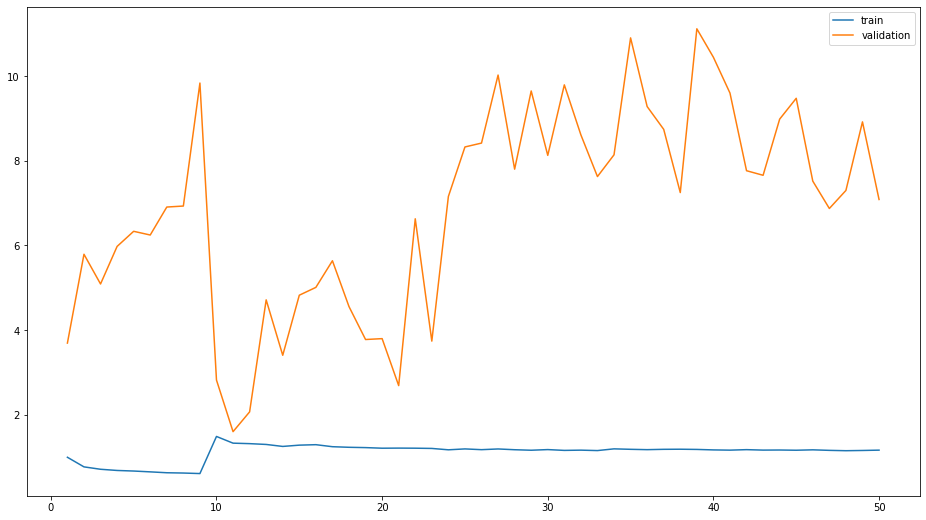

average epoch duration 15.126233315467834
stdev epoch duration 0.39073625834962417
Training lasted 756.3116657733917


In [45]:
CUDA_LAUNCH_BLOCKING=1 
epochComputationTime =  []
for epoch in range(1, NUM_EPOCH + 1):
    
    for phase_name, phase in phases.items():
        epoach_loss = 0.0
                
        phase_is_training = phase['is_training']
        phase_dataloader = phase['dataloader']
        model.train(phase_is_training)
        
        # Ajust and save the learning rate in the phase dict
        if phase_is_training:
            startEpoch = time.time()
            lr = adjust_lr(optimizer, epoch)
            phase.setdefault('lr', []).append(lr)
            
        # Iterate over each bath in the phase
        for i, batch in enumerate(phase_dataloader, 1):
            #print(i)
            #print(batch[0].shape)
            X_img, X_seq, X_tod, y = batch
            #print(X_img.size(),X_seq.shape,X_tod.shape)

            X_img = X_img.float().cuda()#.to(device, dtype=torch.float)
            X_seq = X_seq.float().cuda()#.to(device, dtype=torch.float)
            X_tod = X_tod.float().cuda()#.to(device, dtype=torch.float)
            y = y.long().cuda()#.to(device, dtype=torch.int64)

            with torch.set_grad_enabled(phase_is_training):
                out = model(X_img, X_seq, X_tod)
                loss = criterion(out, y)

            if phase_is_training:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.4)
                optimizer.step()
        
            epoach_loss += loss.item()
        
        # Save the loss for the epoch in the phase dict
        phase.setdefault('loss', []).append(epoach_loss/i)
        if phase_is_training:
            endEpoch = time.time()
            epochComputationTime.append(endEpoch-startEpoch)
            
        
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize = (16, 9))
    #ax.set_yscale('log')
    
    for phase_name, phase in phases.items():
        ax.plot(np.arange(1, epoch + 1), phase['loss'], label = phase_name)        
    
    ax.legend()
    plt.show();
    print(f'average epoch duration {np.mean(epochComputationTime)}')
    print(f'stdev epoch duration {np.std(epochComputationTime)}')
    print(f'Training lasted {np.sum(epochComputationTime)}')

In [46]:
torch.save(model.state_dict(), os.getcwd()+"/trained_modelC_ch11_vol1")

### Validation/Test prediction loop

In [47]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    phase_dataloader = phase['dataloader']
    phase['predicted'] = []
    phase['true'] = []
    
    for i, batch in enumerate(phase_dataloader, 1):
        X_img, X_seq, X_tod, y = batch

        phase['true'].extend(list(y.numpy()))
        
        X_img = X_img.float().cuda()#.to(device, dtype=torch.float)
        X_seq = X_seq.float().cuda()#.to(device, dtype=torch.float)
        X_tod = X_tod.float().cuda()#.to(device, dtype=torch.float)
        y = y.float().cuda()#.to(device, dtype=torch.float)
        
        with torch.no_grad():
            out = model(X_img, X_seq, X_tod)
            probability, predicted = torch.max(out, 1)
            
        phase['predicted'].extend(list(predicted.cpu().numpy()))        

### Final results

In [48]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    print(phase_name)
    print(classification_report(phase['true'], phase['predicted'], target_names = ['0','1','2','3','4','5','6','7','8']))

validation
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.87      0.29      0.44     11543
           2       0.01      0.01      0.01       283
           3       0.06      0.77      0.11       543
           4       0.08      0.10      0.09       375
           5       0.05      0.14      0.07       367
           6       0.27      0.07      0.11       102
           7       0.71      0.14      0.23       185
           8       0.31      0.54      0.40       849

    accuracy                           0.31     14247
   macro avg       0.26      0.23      0.16     14247
weighted avg       0.74      0.31      0.39     14247



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
np.sort(data_train.labelC.unique())

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=object)

In [50]:
class_weights

[1.0676596361527868,
 20.27598072952512,
 6.063181724634698,
 1.0,
 2.055753262158956,
 2.088543882036013,
 8.778605482717522,
 0.29443628259327,
 4.505428964673498]